Note: you may need to restart the kernel to use updated packages.
Path to dataset files: C:\Users\plui0\.cache\kagglehub\datasets\shayanfazeli\heartbeat\versions\1
Files in dataset folder:
['mitbih_test.csv', 'mitbih_train.csv', 'ptbdb_abnormal.csv', 'ptbdb_normal.csv']
Path to dataset files: C:\Users\plui0\.cache\kagglehub\datasets\shayanfazeli\heartbeat\versions\1
Files in dataset folder:
['mitbih_test.csv', 'mitbih_train.csv', 'ptbdb_abnormal.csv', 'ptbdb_normal.csv']
Original shape: (99195, 187)
Dropping 54 columns with ≥80.0% zeros
Dropping 54 columns with ≥80.0% zeros
132    0.793014
131    0.785372
130    0.778285
129    0.769333
128    0.760048
127    0.750451
126    0.739201
125    0.726135
124    0.714361
123    0.700055
122    0.684994
121    0.668179
120    0.650890
119    0.634578
118    0.619890
117    0.603982
116    0.589364
115    0.576219
114    0.563889
113    0.551258
dtype: float64
Original shape: (99195, 187)
Dropping 54 columns with ≥80.0% zeros
Dropping 54 colum

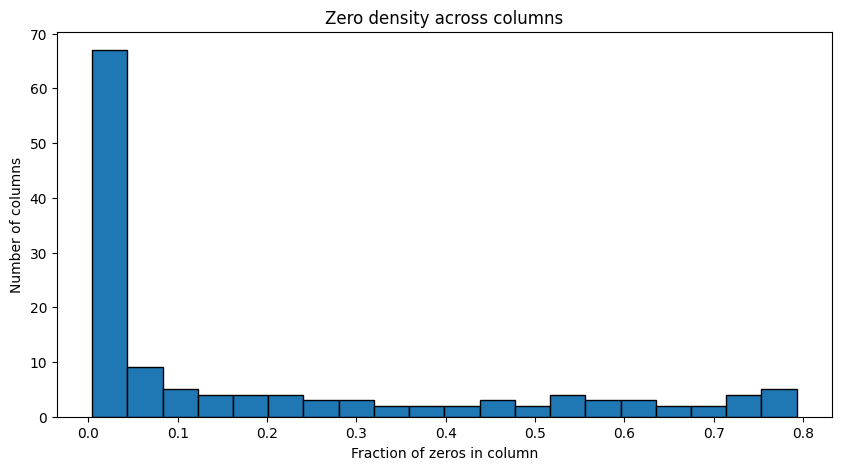

Columns with all zeros: []
Count: 0
Cleaned shape: (99195, 133)
Accuracy: 0.24843768898923518
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.17      0.29     18118
         1.0       0.13      0.49      0.21       556
         2.0       0.23      0.45      0.31      1448
         3.0       0.03      0.95      0.05       162
         4.0       0.49      0.72      0.59      1608
         6.0       0.09      0.70      0.15       834
         7.0       0.11      0.09      0.10      2077

    accuracy                           0.25     24803
   macro avg       0.28      0.51      0.24     24803
weighted avg       0.71      0.25      0.29     24803

Confusion Matrix:
 [[3169 1548 1606 4787  844 5123 1041]
 [  38  273   45  117   14   62    7]
 [  95   77  648  193  154  130  151]
 [   4    0    3  154    0    0    1]
 [  79   16   36   26 1153   82  216]
 [  24   64   58   71   16  585   16]
 [ 168  109  373  315  152  780  180]]

In [14]:
# ==================== INSTALL & SETUP ====================
%pip install tensorflow --quiet

# Run preprocessing notebook (should define X_train, X_test, y_train, y_test)
%run FeatureEngineering.ipynb

import os
os.system("winget install -e --id Microsoft.VC++2015-2019Redist-x64")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, recall_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [15]:
# ==================== DATA PREP ====================
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.astype(int)
y_test = y_test.values.astype(int)

# Merge class 6 into 0 ("Normal"), rename 7 to 5 ("Abnormal")
y_train = np.where(y_train == 6, 0, y_train)
y_test = np.where(y_test == 6, 0, y_test)
y_train = np.where(y_train == 7, 5, y_train)
y_test = np.where(y_test == 7, 5, y_test)

unique_classes = np.unique(np.concatenate([y_train, y_test]))
num_classes = unique_classes.max() + 1

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for 1D CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# One-hot encode
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)


In [16]:
# ==================== MANUAL CLASS WEIGHTS ====================
# Tuned to improve recall for minority classes without hurting precision too much
class_weights = {
    0: 1.0,   # Normal
    1: 4.0,   # Supraventricular
    2: 1.5,   # Ventricular
    3: 5.0,   # Fusion
    4: 1.0,   # Unknown
    5: 1.2    # Abnormal
}


In [17]:
# ==================== FOCAL LOSS DEFINITION ====================
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Loss

class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=0.5):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = self.alpha * K.pow(1 - y_pred, self.gamma)
        return K.sum(weight * cross_entropy, axis=1)


In [18]:
# ==================== BUILD CNN ====================
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss=FocalLoss(gamma=2.0, alpha=0.5), metrics=['accuracy'])
model.summary()


c:\Users\plui0\anaconda3\envs\tfcpu\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 129, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 62, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │       198,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,506 (802.76 KB)

 Trainable params: 205,506 (802.76 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# ==================== TRAIN MODEL ====================
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=128,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8214 - loss: 0.2273 - val_accuracy: 0.8944 - val_loss: 0.0690
Epoch 2/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8214 - loss: 0.2273 - val_accuracy: 0.8944 - val_loss: 0.0690
Epoch 2/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8873 - loss: 0.1105 - val_accuracy: 0.9174 - val_loss: 0.0534
Epoch 3/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8873 - loss: 0.1105 - val_accuracy: 0.9174 - val_loss: 0.0534
Epoch 3/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9024 - loss: 0.0874 - val_accuracy: 0.9309 - val_loss: 0.0394
Epoch 4/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9024 - loss: 0.0874 - val_accuracy: 0.9309 - val_loss: 0.0394
Epoch 4/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9149 - loss: 0.0732 - val_accuracy: 0.9438 - val_loss: 0.0333
Epoch 5/30
775/775 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9149 - loss: 0.0732 - val_accura

In [20]:
# ==================== EVALUATE MODEL ====================
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))


776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9742 - loss: 0.0130
Test Accuracy: 0.9765
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9742 - loss: 0.0130
Test Accuracy: 0.9765
776/776 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
776/776 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     18952
           1       0.80      0.82      0.81       556
           2       0.96      0.94      0.95      1448
           3       0.72      0.84      0.77       162
           4       1.00      0.98      0.99      1608
           5       0.96      0.95      0.96      2077

    accuracy                           0.98     24803
   macro avg       0.90      0.92      0.91     24803
weighted avg       0.98      0.98      0.98     24803

Recall (macro): 0.9192618901149152
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99

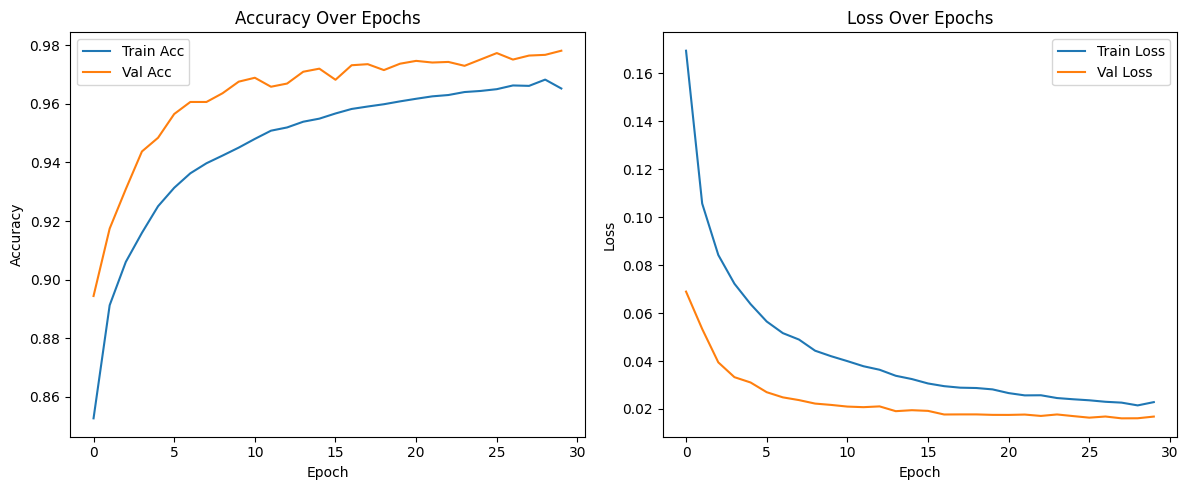

In [21]:
# ==================== PLOT HISTORY ====================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


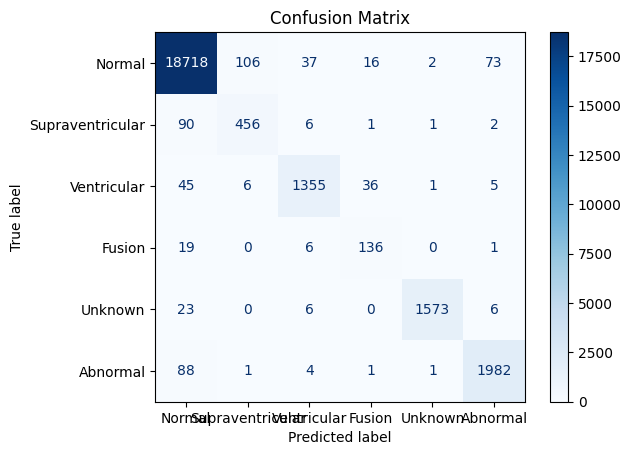

In [22]:
# ==================== CONFUSION MATRIX ====================
label_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown', 'Abnormal']
cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
cmd = ConfusionMatrixDisplay(cm, display_labels=label_names)
cmd.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


C:\Users\plui0\AppData\Local\Temp\ipykernel_23444\442370979.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


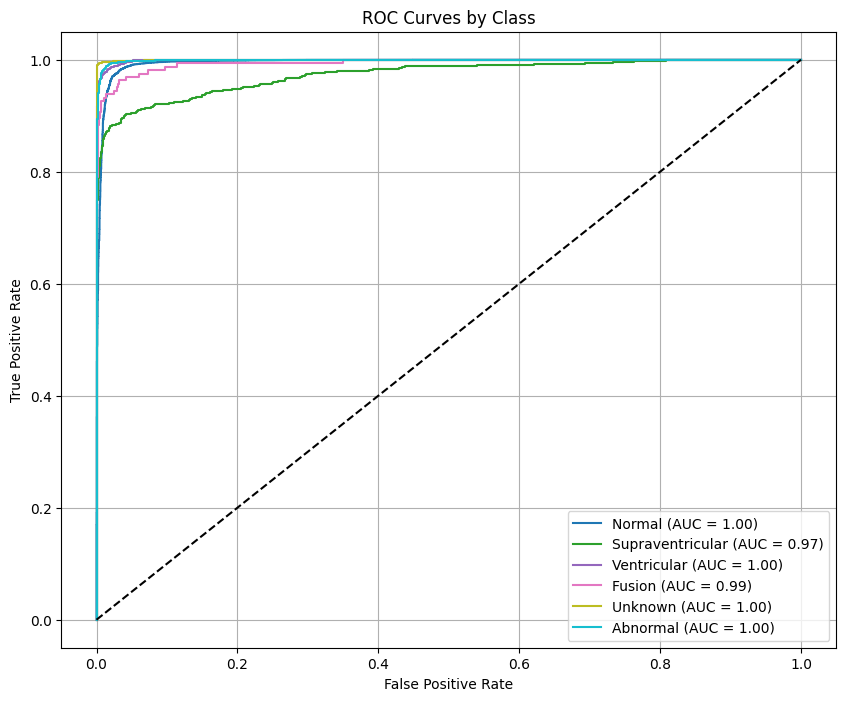

In [23]:
# ==================== ROC & AUC ====================
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', num_classes)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{label_names[i]} (AUC = {roc_auc[i]:.2f})", color=colors(i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
